## 26x26のウエハに限定して機械学習させる
- データオーギュメンテーション（鏡映，回転を追加）

### import，入力データの読み込み

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/LSWMD.pkl


In [2]:
import os
from os.path import join
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

import numpy as np
import pandas as pd
import cv2

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 


import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import random
random.seed(1)

datapath = join('data', 'wafer')

print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

using GPU: 0,1


Using TensorFlow backend.


['LSWMD.pkl']


### データについて

In [3]:
df=pd.read_pickle("../input/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


- データセットは811,457枚のウエハマップから構成されている．

- ウエハマップのそれぞれの列から得られる情報はないが，インスタンスごとにダイサイズが異なることがわかる．
- ウエハマップのダイサイズをチェックするための変数`WaferMapDim`を定義する．（縦，横の値）

In [4]:
df = df.drop(['waferIndex'], axis = 1)

In [5]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
675837,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",592.0,lot42042,[[Test]],[[none]],"(29, 27)"
323572,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4423.0,lot19571,[],[],"(74, 76)"
743596,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1421.0,lot44788,[[Test]],[[none]],"(43, 42)"
227197,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7810.0,lot14277,[],[],"(89, 112)"
710247,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",516.0,lot43436,[[Training]],[[none]],"(25, 27)"


- 不良パターンと学習orテストラベルを数値で表す．

In [6]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [7]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [8]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

### 26x26のデータに対して処理

In [9]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [10]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [11]:
mask_x = np.zeros((24, 24))
dummy_x = cv2.resize(x[0], (24,24))
mask_x[dummy_x == 1] = 1 
mask_x[dummy_x == 2] = 1 
mask_x = mask_x.reshape((1, 24,24))

In [12]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


- 26x26のウエハが14366枚抽出できた．

- 最初のデータを可視化してみる．
- その前に，26x26のデータでおかしなものを表示

In [13]:
for i in range(len(x)):
    error = np.where((x[0] != x[i]) & ((x[0] == 0) | (x[i] == 0)))
    if len(error[0]) > 0:
        print(str(i) + " is error")
        #print(error)

6267 is error
6268 is error
6269 is error
6270 is error
6271 is error
6272 is error
6273 is error
6274 is error
6275 is error
6276 is error
6277 is error
6278 is error
6279 is error
6280 is error
6281 is error
6282 is error


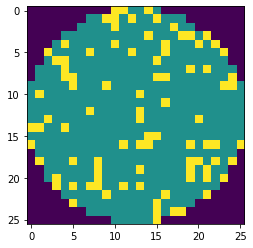

Faulty case : ['none'] 


In [14]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

- おかしなウエハは除去する

In [15]:
error_list = []
for i in range(len(x)):
    error = np.where((x[0] != x[i]) & ((x[0] == 0) | (x[i] == 0)))
    if len(error[0]) > 0:
        error_list.append(i)
x = np.delete(x, error_list, 0)
y = np.delete(y, error_list, 0)
print(x.shape)
print(y.shape)

(14350, 26, 26)
(14350, 1)


- 形が異なるウエハを削除したところ，14350枚となった．

In [16]:
x = x.reshape((-1, 26, 26, 1))
x.shape

(14350, 26, 26, 1)

In [17]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [18]:
faulty_case_dict = dict()

In [19]:
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y[y==f])))
    faulty_case_dict[i] = f

Center : 90
Donut : 1
Edge-Loc : 289
Edge-Ring : 23
Loc : 297
Near-full : 16
Random : 74
Scratch : 71
none : 13489


- 14366枚の26x26ウエハの不良パターンは上記のようになっている．

In [20]:
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [21]:
new_x.shape

(14350, 26, 26, 3)

- new_xを(14366, 26, 26, 3)とし，最後の次元にはウエハの値(0, 1, 2)がそれぞれの値毎にベクトルとしてまとめられている．
- ウエハデータの各ピクセルは，0:ウエハなし，1:正常，2:不良を表す．

### テストデータに分割
- ランダムなリストを生成する

In [22]:
def rand_ints_nodup(a, b, k):
    ns = []
    while len(ns) < k:
        n = random.randint(a, b)
        if not n in ns:
            ns.append(n)
    return ns

In [23]:
testsize = 2500
randlist = rand_ints_nodup(0, new_x.shape[0], testsize)

- tempx, tempyにテストデータを分割
- new_x, yからその分を削除

In [24]:
tempx = new_x.copy()[randlist, :, :, :]
tempy = y.copy()[randlist, :]

In [25]:
for f in faulty_case :
    print('{} : {}'.format(f, len(tempy[tempy==f])))

Center : 16
Donut : 0
Edge-Loc : 53
Edge-Ring : 3
Loc : 53
Near-full : 2
Random : 13
Scratch : 14
none : 2346


In [26]:
new_x = np.delete(new_x, randlist, axis=0)
y = np.delete(y, randlist, axis=0)

### オートエンコーダで学習

#### エンコーダとデコーダのモデルを学習

- モデルの定義をする．

In [27]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [28]:
ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26, 26, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 13, 13, 64)        36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 26, 26, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_______________________________________________________

- 層は
    - 入力層
    - 畳み込み層
    - プーリング層
    - 転置畳み込み層
    - アップサンプリング層

In [29]:
epoch=30
batch_size=1024

- 学習を開始する．
- `new_x`を`new_x`にエンコードしデコードする．

In [30]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=1)

Epoch 1/30
11850/11850 [==============================] - 2s 129us/step - loss: 0.1631
Epoch 2/30
11850/11850 [==============================] - 0s 38us/step - loss: 0.1007
Epoch 3/30
11850/11850 [==============================] - 0s 40us/step - loss: 0.0887
Epoch 4/30
11850/11850 [==============================] - 0s 40us/step - loss: 0.0783
Epoch 5/30
11850/11850 [==============================] - 0s 41us/step - loss: 0.0699
Epoch 6/30
11850/11850 [==============================] - 0s 40us/step - loss: 0.0632
Epoch 7/30
11850/11850 [==============================] - 0s 40us/step - loss: 0.0581
Epoch 8/30
11850/11850 [==============================] - 0s 41us/step - loss: 0.0537
Epoch 9/30
11850/11850 [==============================] - 0s 41us/step - loss: 0.0500
Epoch 10/30
11850/11850 [==============================] - 0s 42us/step - loss: 0.0466
Epoch 11/30
11850/11850 [==============================] - 0s 42us/step - loss: 0.0429
Epoch 12/30
11850/11850 [==========================

- エンコーダだけのモデルを定義する．

In [31]:
encoder = models.Model(input_tensor, latent_vector)

- デコーダだけのモデルを定義する．

In [32]:
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

- `encoder`を使って元のウエハ画像をエンコードする．

In [33]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

- エンコードされた潜伏的な不良ウエハにノイズを負荷する．

In [34]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

- 元のウエハ画像

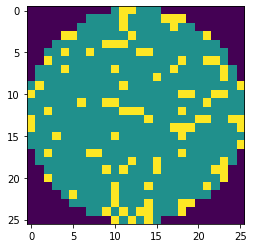

In [35]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

- マスクの定義

In [36]:
# 0がウエハ領域，1が範囲外
mask = new_x[0, :, :, 0].copy()
#out_region = np.where(mask == 1.0)
#in_region = np.where(mask == 0.0)
#mask[out_region] = 0.0
#mask[in_region] = 1.0
#print(mask)

- 回転の実験

90度ごとなら自作OpenCV関数が有用

- 90度以外の回転

In [37]:
from PIL import Image, ImageOps
def rotation_pil_mask(img, degree):
    src = Image.fromarray(np.uint8(img))
    img_rotate = np.array(src.rotate(degree))
    
    #before
    '''
    plt.imshow(np.argmax(img_rotate, axis=2))
    plt.title("rotate " + str(degree) + " degree before")
    plt.show()
    '''
    
    #マスクの適用, 
    out_region = np.where((np.argmax(img_rotate, axis=2) != 0) & (mask > 0.0))
    img_rotate[out_region[0], out_region[1]] = np.array([1., 0., 0.])
    in_region = np.where((np.argmax(img_rotate, axis=2) == 0) & (mask == 0.0))
    img_rotate[in_region[0], in_region[1]] = np.array([0., 1., 0.])

    #after
    '''plt.imshow(np.argmax(img_rotate, axis=2))
    plt.title("rotate " + str(degree) + " degree after")
    plt.show()'''

    return img_rotate

# 上下方向の鏡映
def flip_pil_mask(img):
    src = Image.fromarray(np.uint8(img))
    img_flip = np.array(ImageOps.flip(src))
    
    #マスクの適用, 
    out_region = np.where((np.argmax(img_flip, axis=2) != 0) & (mask > 0.0))
    img_flip[out_region[0], out_region[1]] = np.array([1., 0., 0.])
    in_region = np.where((np.argmax(img_flip, axis=2) == 0) & (mask == 0.0))
    img_flip[in_region[0], in_region[1]] = np.array([0., 1., 0.])
    
    return img_flip

# 左右方向の鏡映
def mirror_pil_mask(img):
    src = Image.fromarray(np.uint8(img))
    img_mirror = np.array(ImageOps.mirror(src))
    
    #マスクの適用, 
    out_region = np.where((np.argmax(img_mirror, axis=2) != 0) & (mask > 0.0))
    img_mirror[out_region[0], out_region[1]] = np.array([1., 0., 0.])
    in_region = np.where((np.argmax(img_mirror, axis=2) == 0) & (mask == 0.0))
    img_mirror[in_region[0], in_region[1]] = np.array([0., 1., 0.])
    
    return img_mirror

In [38]:
'''
wafer = new_x[np.where(y=="Edge-Loc")[0]].reshape(len(np.where(y=="Edge-Loc")[0]), 26, 26, 3)
#plt.imshow(np.argmax(wafer[0], axis=2))
#plt.show()

print(wafer[0].shape)

for i in range(19):
    rotation_pil_mask(wafer[0], i*20)
'''

'\nwafer = new_x[np.where(y=="Edge-Loc")[0]].reshape(len(np.where(y=="Edge-Loc")[0]), 26, 26, 3)\n#plt.imshow(np.argmax(wafer[0], axis=2))\n#plt.show()\n\nprint(wafer[0].shape)\n\nfor i in range(19):\n    rotation_pil_mask(wafer[0], i*20)\n'

- ノイズが付加されたウエハ画像

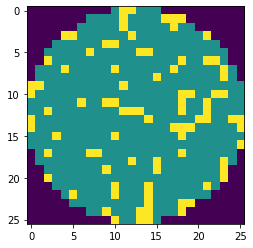

In [39]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

### データオーギュメンテーション

- データオーギュメンテーションを行う関数を定義する．
- 鏡映，回転を行う

In [40]:
# augment function define (add rotate, flip)
def gen_data(wafer, label):
    # Encode input wafer
    #encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    aug_x = np.zeros((1, 26, 26, 3))
    
    #datagen = ImageDataGenerator(rotation_range = 90, horizontal_flip = True, vertical_flip = True, fill_mode = 'constant', cval = 0)
    #datagen = ImageDataGenerator(rotation_range = 0)
    ite = 5 if label != 'none' else 1
    for i in range(len(wafer)):
        for j in range(ite):
#             rotatedata = wafer[i]
            angle = int(180 / ite)
            if label != 'none':
                rotatedata = rotation_pil_mask(wafer[i], j * angle)
            else:
                rotatedata = rotation_pil_mask(wafer[i], j * angle)
            flipdata = flip_pil_mask(rotatedata)
            flipmirrordata = mirror_pil_mask(flipdata)
            mirrordata = mirror_pil_mask(rotatedata)
            rotatedata = rotatedata.reshape(1, 26, 26, 3)
            flipdata = flipdata.reshape(1, 26, 26, 3)
            flipmirrordata = flipmirrordata.reshape(1, 26, 26, 3)
            mirrordata = mirrordata.reshape(1, 26, 26, 3)
            aug_x = np.concatenate((aug_x, rotatedata, flipdata, flipmirrordata, mirrordata), axis = 0)
#             aug_x = np.concatenate((aug_x, rotatedata), axis = 0)
            '''
            for j, img in enumerate(data):
                plot_num = j+1
                plt.subplot(4, 5, plot_num)
                plt.tick_params(labelbottom=False)
                plt.tick_params(labelleft=False)
                plt.imshow(img)
            plt.show()
            '''
    aug_x = aug_x[1:]
    encoded_x = encoder.predict(aug_x)
    print(encoded_x.shape)
        
    
    # Make wafer until total # of wafer to 15000
    if label != 'none':
        for i in range((13000//len(encoded_x)) + 1):
            noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
#             noised_encoded_x = encoded_x
            noised_gen_x = decoder.predict(noised_encoded_x)
            gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    else:
        gen_x = aug_x
        
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

- データオーギュメンテーション（ノイズ付加）したものが適切か調べる

一番左が元画像
右がデータオーギュメンテーション後

In [41]:
# backup
bu_new_x = new_x.copy()
bu_y = y.copy()

In [42]:
# new_x = bu_new_x.copy()
# y = bu_y.copy()
# gen_x = []

- 不良ラベルが付いているデータに対してデータオーギュメンテーションを行う．

In [43]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

(1480, 13, 13, 64)
(20, 13, 13, 64)
(4720, 13, 13, 64)
(400, 13, 13, 64)
(4880, 13, 13, 64)
(280, 13, 13, 64)
(1220, 13, 13, 64)
(1140, 13, 13, 64)


In [44]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (120450, 26, 26, 3), new_y shape : (120450, 1)


In [45]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))
new_y = y

Center : 13394
Donut : 13021
Edge-Loc : 14396
Edge-Ring : 13220
Loc : 14884
Near-full : 13174
Random : 13481
Scratch : 13737
none : 11143


- ノイズ付加後におかしなデータがあるかチェック
- 元データとずれがあるもの：1689枚

### ノイズ付加後もマスクで直す

In [46]:
backup_new_x = new_x.copy()
backup_new_y = new_y.copy()

In [47]:
count = 0
for i in range(len(new_x)):
    error = np.where((np.argmax(new_x[0], axis=2) != np.argmax(new_x[i], axis=2)) & (np.argmax(new_x[0], axis=2) == 0))
    if len(error[0]) > 0:
        #print(str(i) + "error")
        #print(error)
        count += 1
print(count)

for i in range(len(new_x)):
    #マスクの適用, 
    out_region = np.where((np.argmax(new_x[i], axis=2) != 0) & (mask > 0.0))
    new_x[i, out_region[0], out_region[1]] = np.array([1., 0., 0.])
    in_region = np.where((np.argmax(new_x[i], axis=2) == 0) & (mask == 0.0))
    new_x[i, in_region[0], in_region[1]] = np.array([0., 1., 0.])
    
count = 0
for i in range(len(new_x)):
    error = np.where((np.argmax(new_x[0], axis=2) != np.argmax(new_x[i], axis=2)) & (np.argmax(new_x[0], axis=2) == 0))
    if len(error[0]) > 0:
        #print(str(i) + "error")
        #print(error)
        count += 1
print(count)


'''plt.imshow(np.argmax(new_x[14397], axis=2))
plt.show()
plt.imshow(np.argmax(new_x[0], axis=2))
plt.show()'''

88495
0


'plt.imshow(np.argmax(new_x[14397], axis=2))\nplt.show()\nplt.imshow(np.argmax(new_x[0], axis=2))\nplt.show()'

- データオーギュメンテーションを行った結果，各不良データごとに約40000枚に増えた．
- 合計は368112枚となった．

In [48]:
# x = [0,1,2,3,4,5,6,7,8]
# labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full','none']

# for k in x:
#     fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(20, 20))
#     ax = ax.ravel(order='C')
#     for j in [k]:
#         index = np.where(new_y==labels2[j])[0]
#         img = new_x[index]
#         #img = new_x[0:10]
#         for i in range(10):
#             ax[i].imshow(np.argmax(img[i+0], axis=2))
#             ax[i].set_title(new_y[index[i+0]], fontsize=15)
#             #ax[i].set_xlabel(df_withpattern.index[img.index[i]], fontsize=10)
#             ax[i].set_xticks([])
#             ax[i].set_yticks([])
#     plt.tight_layout()
#     plt.show() 

### 学習を行う
- 不良ラベルを0-8の9次元のベクトルとして表現する．
- one-hotエンコーディングを行っている．

In [49]:
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    tempy[tempy==l] = i

In [50]:
# one-hot-encoding
new_y = to_categorical(new_y)
tempy = to_categorical(tempy)

In [51]:
new_X=new_x
new_Y=new_y

- 学習データとテストデータに分割する．

In [52]:
x_train, x_test, y_train, y_test = train_test_split(new_X, new_Y,
                                                    test_size=0.33,
                                                    random_state=2019)
# x_train = new_X
# x_test = tempx
# y_train = new_Y
# y_test = tempy

In [53]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (80701, 26, 26, 3), y : (80701, 9)
Test x: (39749, 26, 26, 3), y : (39749, 9)


- 学習データ246635枚，テストデータ121477枚．

- モデルの定義を行う．

### CNN

In [54]:
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
def create_model():


    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

- 3-Fold Cross validationで分割して学習する．

In [55]:
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=1) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/30
53800/53800 [==============================] - 6s 118us/step - loss: 1.0865 - accuracy: 0.6130
Epoch 2/30
53800/53800 [==============================] - 6s 103us/step - loss: 0.3483 - accuracy: 0.8740
Epoch 3/30
53800/53800 [==============================] - 6s 103us/step - loss: 0.2093 - accuracy: 0.9272
Epoch 4/30
53800/53800 [==============================] - 6s 104us/step - loss: 0.1356 - accuracy: 0.9549
Epoch 5/30
53800/53800 [==============================] - 6s 104us/step - loss: 0.0913 - accuracy: 0.9703
Epoch 6/30
53800/53800 [==============================] - 6s 103us/step - loss: 0.0581 - accuracy: 0.9817
Epoch 7/30
53800/53800 [==============================] - 6s 103us/step - loss: 0.0325 - accuracy: 0.9912
Epoch 8/30
53800/53800 [==============================] - 6s 103us/step - loss: 0.5271 - accuracy: 0.8579
Epoch 9/30
53800/53800 [==============================] - 6s 103us/step - loss: 0.1285 - accuracy: 0.9569
Epoch 10/30
53800/53800 [=====================

53801/53801 [==============================] - 6s 106us/step - loss: 0.0753 - accuracy: 0.9765
Epoch 17/30
53801/53801 [==============================] - 6s 106us/step - loss: 0.0378 - accuracy: 0.9904
Epoch 18/30
53801/53801 [==============================] - 6s 106us/step - loss: 0.0245 - accuracy: 0.9943
Epoch 19/30
53801/53801 [==============================] - 6s 106us/step - loss: 0.0164 - accuracy: 0.9969
Epoch 20/30
53801/53801 [==============================] - 6s 106us/step - loss: 0.0124 - accuracy: 0.9975
Epoch 21/30
53801/53801 [==============================] - 6s 106us/step - loss: 0.0106 - accuracy: 0.9977
Epoch 22/30
53801/53801 [==============================] - 6s 108us/step - loss: 0.0100 - accuracy: 0.9979
Epoch 23/30
53801/53801 [==============================] - 6s 108us/step - loss: 0.0082 - accuracy: 0.9979
Epoch 24/30
53801/53801 [==============================] - 6s 108us/step - loss: 0.0077 - accuracy: 0.9982
Epoch 25/30
53801/53801 [========================

- Cross validiationによる精度は99.55%であった．

- Cross validationなしで学習する．

In [56]:
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=epoch,
         batch_size=batch_size,
         verbose=1           
         )

Train on 80701 samples, validate on 39749 samples
Epoch 1/30
80701/80701 [==============================] - 11s 136us/step - loss: 0.7779 - accuracy: 0.7338 - val_loss: 0.2927 - val_accuracy: 0.8875
Epoch 2/30
80701/80701 [==============================] - 11s 131us/step - loss: 0.2429 - accuracy: 0.9148 - val_loss: 0.1554 - val_accuracy: 0.9485
Epoch 3/30
80701/80701 [==============================] - 10s 129us/step - loss: 0.1115 - accuracy: 0.9627 - val_loss: 0.0987 - val_accuracy: 0.9659
Epoch 4/30
80701/80701 [==============================] - 10s 129us/step - loss: 0.0604 - accuracy: 0.9808 - val_loss: 0.0589 - val_accuracy: 0.9815
Epoch 5/30
80701/80701 [==============================] - 10s 130us/step - loss: 0.0298 - accuracy: 0.9922 - val_loss: 0.0523 - val_accuracy: 0.9825
Epoch 6/30
80701/80701 [==============================] - 10s 130us/step - loss: 0.0214 - accuracy: 0.9944 - val_loss: 0.0411 - val_accuracy: 0.9884
Epoch 7/30
80701/80701 [==============================] 

- テストデータで評価．    

In [57]:
score = model.score(x_test, y_test)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)

39749/39749 [==============================] - 2s 42us/step
Testing Accuracy: 0.9899871945381165


- データオーギュメンテーションなしの実データで評価

In [58]:
score = model.score(tempx, tempy)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)

2500/2500 [==============================] - 0s 69us/step
Testing Accuracy: 0.9764000177383423


- acuurayは99.70%であった．

- モデルは以下．
    - 入力層
    - 畳み込み層3つ
    - Flatten層（1次元に）
    - 全結合層3つ

In [59]:
model.model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 26, 26, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 64)        9280      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 26, 26, 128)       73856     
_________________________________________________________________
flatten_4 (Flatten)          (None, 86528)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               44302848  
_________________________________________________________________
dense_11 (Dense)             (None, 128)               6566

- accuracyグラフ，lossグラフは以下．
- 5epoch程度で落ち着いている．

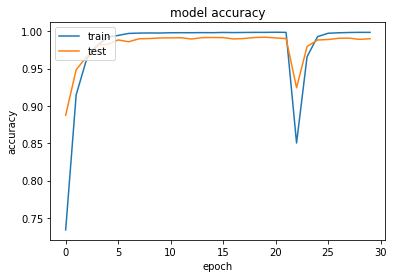

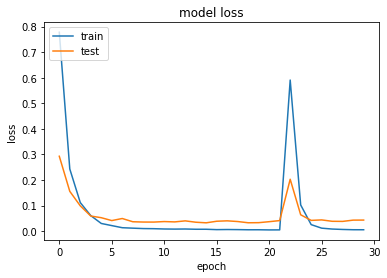

In [60]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [61]:
#y_train_pred = np.argmax(model.predict(x_train))
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
y_train_max = np.argmax(y_train, axis=1)
y_test_max = np.argmax(y_test, axis=1)

print(y_train_max[0])
print(y_train_pred[0])

train_acc2 = np.sum(y_train_max == y_train_pred, axis=0, dtype='float') / x_train.shape[0]
test_acc2 = np.sum(y_test_max == y_test_pred, axis=0, dtype='float') / x_test.shape[0]
print('Training acc: {}'.format(train_acc2*100))
print('Testing acc: {}'.format(test_acc2*100))
print("y_train_pred[:100]: ", y_train_pred[:100])
print ("y_train_max[:100]: ", y_train_max[:100])

39749/39749 [==============================] - 2s 40us/step
0
0
Training acc: 99.86493352003073
Testing acc: 98.99871694885405
y_train_pred[:100]:  [0 5 2 2 6 6 1 0 1 5 5 0 0 8 5 6 1 3 3 1 3 1 5 0 4 1 3 1 3 2 1 0 4 1 8 4 0
 7 2 5 4 4 5 4 7 6 5 3 5 3 7 6 4 1 1 3 5 8 8 3 4 2 7 0 0 7 5 8 0 1 1 2 1 6
 6 7 8 7 8 3 5 3 5 5 6 4 8 7 6 3 6 8 8 3 1 2 0 4 7 5]
y_train_max[:100]:  [0 5 2 2 6 6 1 0 1 5 5 0 0 8 5 6 1 3 3 1 3 1 5 0 4 1 3 1 3 2 1 0 4 1 8 4 0
 7 2 5 4 4 5 4 7 6 5 3 5 3 7 6 4 1 1 3 5 8 8 3 4 2 7 0 0 7 5 8 0 1 1 2 1 6
 6 7 8 7 8 3 5 3 5 5 6 4 8 7 6 3 6 8 8 3 1 2 0 4 7 5]


### 混同行列

In [62]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
Normalized confusion matrix


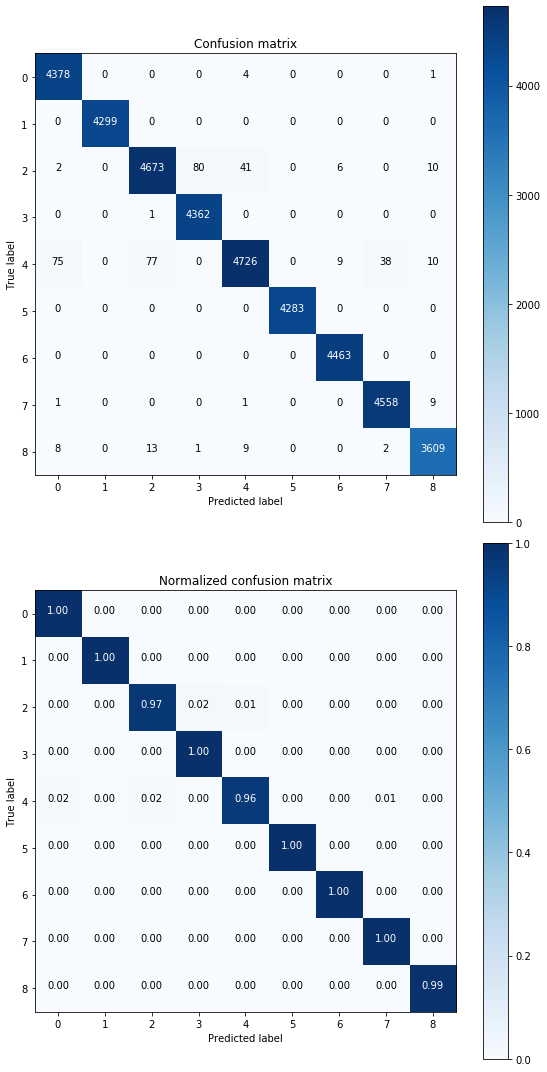

In [63]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_max, y_test_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

### クラス活性化マップ

In [64]:
#set target wafer number
target_wafer_num = 100
# predict 
prob = model.model.predict(x_test[target_wafer_num].reshape(1,26,26,3))

In [65]:
aver_output = model.model.layers[3]
aver_model = models.Model(input_tensor, aver_output.output)
cam_result = aver_model.predict(x_test[target_wafer_num].reshape(1, 26, 26, 3))

In [66]:
print(model.model.layers[3].name)

conv2d_13


In [67]:
weight_result = model.model.layers[-1].get_weights()[0]

In [68]:
cam_result.shape

(1, 26, 26, 128)

In [69]:
mask_x = np.zeros((26, 26))
dummy_x = cv2.resize(x[0], (26,26))
mask_x[dummy_x == 1] = 1 
mask_x[dummy_x == 2] = 1 
mask_x = mask_x.reshape((1, 26,26))

In [70]:
def make_cam(cam_result, weight_result): 
    cam_arr = np.zeros((1,26, 26))
    for row in range(0,9):
        cam = np.zeros((1, 26, 26))
        for i, w in enumerate(weight_result[:, row]):
            cam += (w*cam_result[0,:,:,i]).reshape(26,26)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        cam[mask_x == 0] = 0
        cam_arr = np.concatenate((cam_arr, cam))
    return cam_arr[1:]

def display_activation(cam_arr, prob, wafer): 
    fig, ax = plt.subplots(9, 1, figsize=(50, 50))
    count = 0
    cam_arr[np.percentile(cam_arr, 0.8) > cam_arr] = 0
    for row in range(0,9):
        ax[row].imshow(np.argmax(wafer, axis=2))
        ax[row].imshow(cam_arr[row],cmap='Reds', alpha=0.7)
        ax[row].set_title('class : ' + faulty_case_dict[count]+', prob : {:.4f}'.format(prob[:, count][0]*100) + '%')
        count += 1

In [71]:
faulty_case_dict[np.argmax(y_test[target_wafer_num])]

'Scratch'

faulty case : Scratch


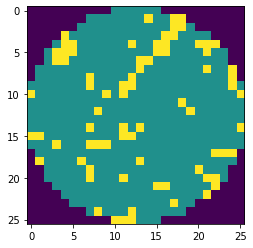

In [72]:
plt.imshow(np.argmax(x_test[target_wafer_num], axis=2))
print('faulty case : {}'.format(faulty_case_dict[np.argmax(y_test[target_wafer_num])]))

- 対象のウエハの画像と不良パターンの表示

In [73]:
cam_result.shape

(1, 26, 26, 128)

In [74]:
cam_arr = make_cam(cam_result, weight_result)

In [75]:
prob.shape

(1, 9)

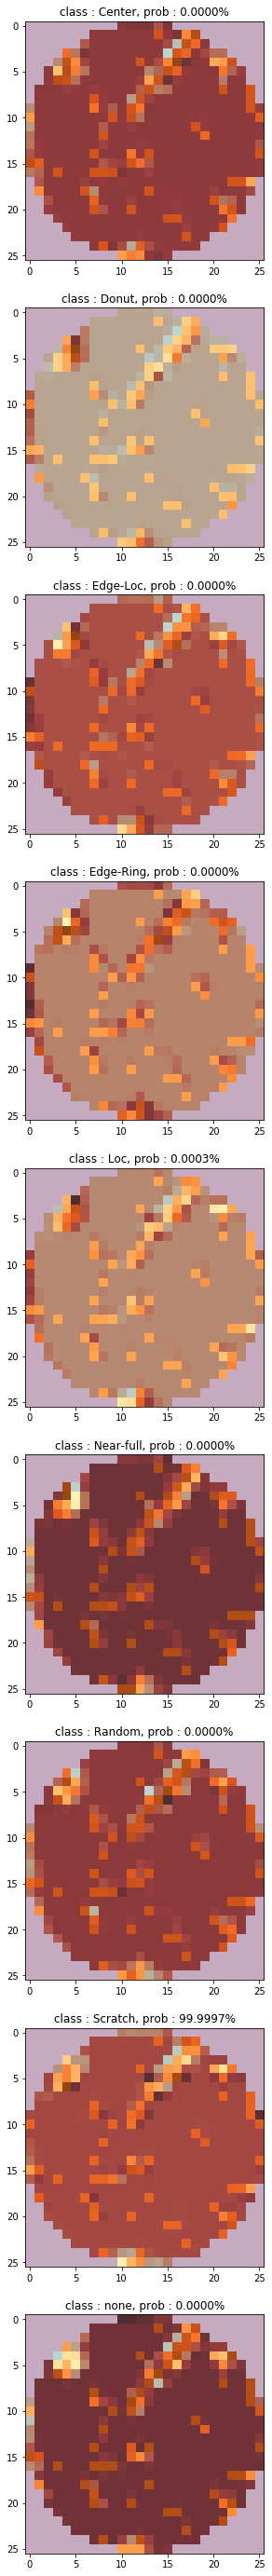

In [76]:
display_activation(cam_arr, prob, x_test[target_wafer_num])

- 活性化マップの表示
- ドーナツでは円形状にヒートマップの赤い部分が点在している